## <a id="toc1_1_"></a>[__Пример работы с классом `SberProcess`__](#toc0_)

**Содержание**<a id="toc0_"></a>
- [__Пример работы с классом `SberProcess`__](#toc1_1_)
    - [__Постановка задачи__](#toc1_1_1_)
    - [__Инициализация объекта класса `SberProcess`__](#toc1_1_2_)
    - [__Работа с одиночным процессом__](#toc1_1_3_)
    - [__Работа с произвольным количеством процессов__](#toc1_1_4_)
    - [__Практический смысл__](#toc1_1_5_)

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
### <a id="toc1_1_1_"></a>[__Постановка задачи__](#toc0_)

* Имея данные об общем числе испытаний и числе испытаний, завершившихся неудачей, оценить процесс по методике "Шесть сигм":
    * определить класс процесса (_красный_, _желтый_, _зеленый_);
    * рассчитать сигму $\sigma$ процесса;
    * рассчитать и визуализировать долю брака.

* Требование единообразия интерфейса: для удобства пользователя предусмотреть возможность работать с произвольным количеством процессов как с одним.

***
### <a id="toc1_1_2_"></a>[__Инициализация объекта класса `SberProcess`__](#toc0_)

Параметры:

* `classifier` — определитель класса качества процесса по его сигме. `SigmaClassifier`.

* `actions` — общее число испытаний. `int | float | list | tuple | numpy.ndarray | pandas.Series`.

* `fails` — число испытаний, завершившихся неудачей. `int | float | list | tuple | numpy.ndarray | pandas.Series`.

* `name` — имя процесса. `str | list | tuple | numpy.ndarray | pandas.Series | None`. По умолчанию `None`.

***
### <a id="toc1_1_3_"></a>[__Работа с одиночным процессом__](#toc0_)

In [1]:
from sberpunk.stats import (
    QualityClass,
    SigmaClassifier,
    SberProcess
)

In [2]:
print(QualityClass.__doc__)


    Quality class defined by a color label and supremum.

    Attributes:
        color (str):
            Quality class color label. Must be a valid `matplotlib` color name.

        supremum (int | float):
            Unreachable upper bound of the sigma interval that corresponds to
            the quality class.

            E.g., "red" class never reaches sigma=2.1 supremum which is the
            exact lower bound of the next, "yellow", class and "yellow" never
            reaches 4.1 which is the lower bound of the "green" class.
    


In [3]:
print(SigmaClassifier.__doc__)


    A classifier responsible for getting the quality class color label for a
    sigma value.

    Attributes:
        quality_classes (list[QualityClass]):
            List of `QualityClass` instances defining the classifier. They are
            not supposed to be sorted by a supremum. A quality class with
            `float("inf")` supremum is mandatory.
    


In [4]:
init_params = [
    ("red", 2.1),
    ("yellow", 4.1),
    ("green", float("inf"))
]

classifier = SigmaClassifier([
    QualityClass(*params)
    for params in init_params
])

In [5]:
print(SberProcess.__doc__)


    Process to evaluate with the "6 sigma" approach.

    Attributes:
        classifier (SigmaClassifier):
            A classifier responsible for getting the quality class color label
            for a given sigma value.

        actions (int | float | list | tuple | numpy.ndarray | pandas.Series):
            Total number of actions.

        fails (int | float | list | tuple | numpy.ndarray | pandas.Series):
            Number of actions qualified as failed.

        name (str | list | tuple | numpy.ndarray | pandas.Series | None):
            Name of the process. Defaults to `None`.
    


In [6]:
process = SberProcess(
    classifier=classifier,
    actions=500,
    fails=59,
    name="A very important process"
)

process.sigma

array([2.68504413])

In [7]:
process.sigma.item()

2.68504412790781

In [8]:
process.label

array(['yellow'], dtype='<U6')

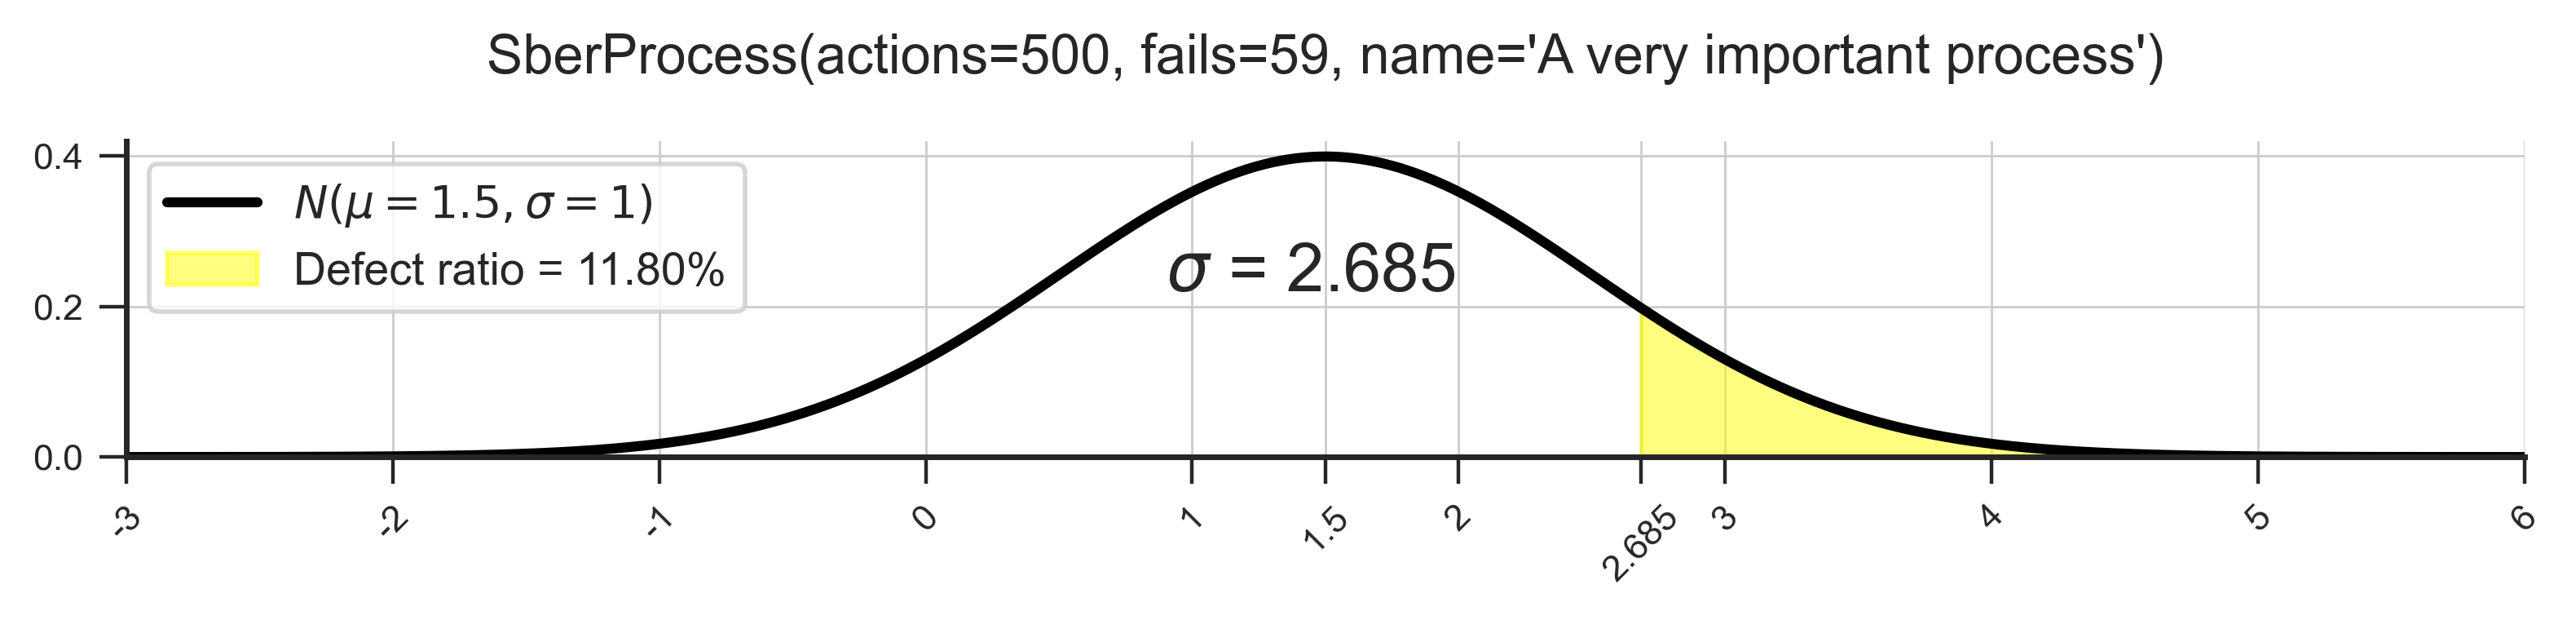

In [9]:
process.plot()

***
### <a id="toc1_1_4_"></a>[__Работа с произвольным количеством процессов__](#toc0_)

Для демонстрации синтезируем данные:

In [10]:
import string
import numpy as np
import pandas as pd

rng = np.random.default_rng(seed=2128506)
total = rng.integers(low=1, high=10**4, size=(10,))

df = pd.DataFrame({
    "ok": total - 200,
    "nok": [200] * 10,
    "total": total,
    "process_name": list(string.ascii_letters[:10])
})

df

,ok,nok,total,process_name
0,1372,200,1572,a
1,3729,200,3929,b
2,6789,200,6989,c
3,5619,200,5819,d
4,7205,200,7405,e
5,443,200,643,f
6,1319,200,1519,g
7,60,200,260,h
8,3903,200,4103,i
9,7345,200,7545,j


In [11]:
bulk = SberProcess(classifier, df.total, df.nok, df.process_name)
df["sigma"] = bulk.sigma
df["label"] = bulk.label
df

,ok,nok,total,process_name,sigma,label
0,1372,200,1572,a,2.639600,yellow
1,3729,200,3929,b,3.136155,yellow
2,6789,200,6989,c,3.401529,yellow
3,5619,200,5819,d,3.320123,yellow
4,7205,200,7405,e,3.426696,yellow
5,443,200,643,f,1.992899,red
6,1319,200,1519,g,2.618552,yellow
7,60,200,260,h,0.763684,red
8,3903,200,4103,i,3.157148,yellow
9,7345,200,7545,j,3.434797,yellow


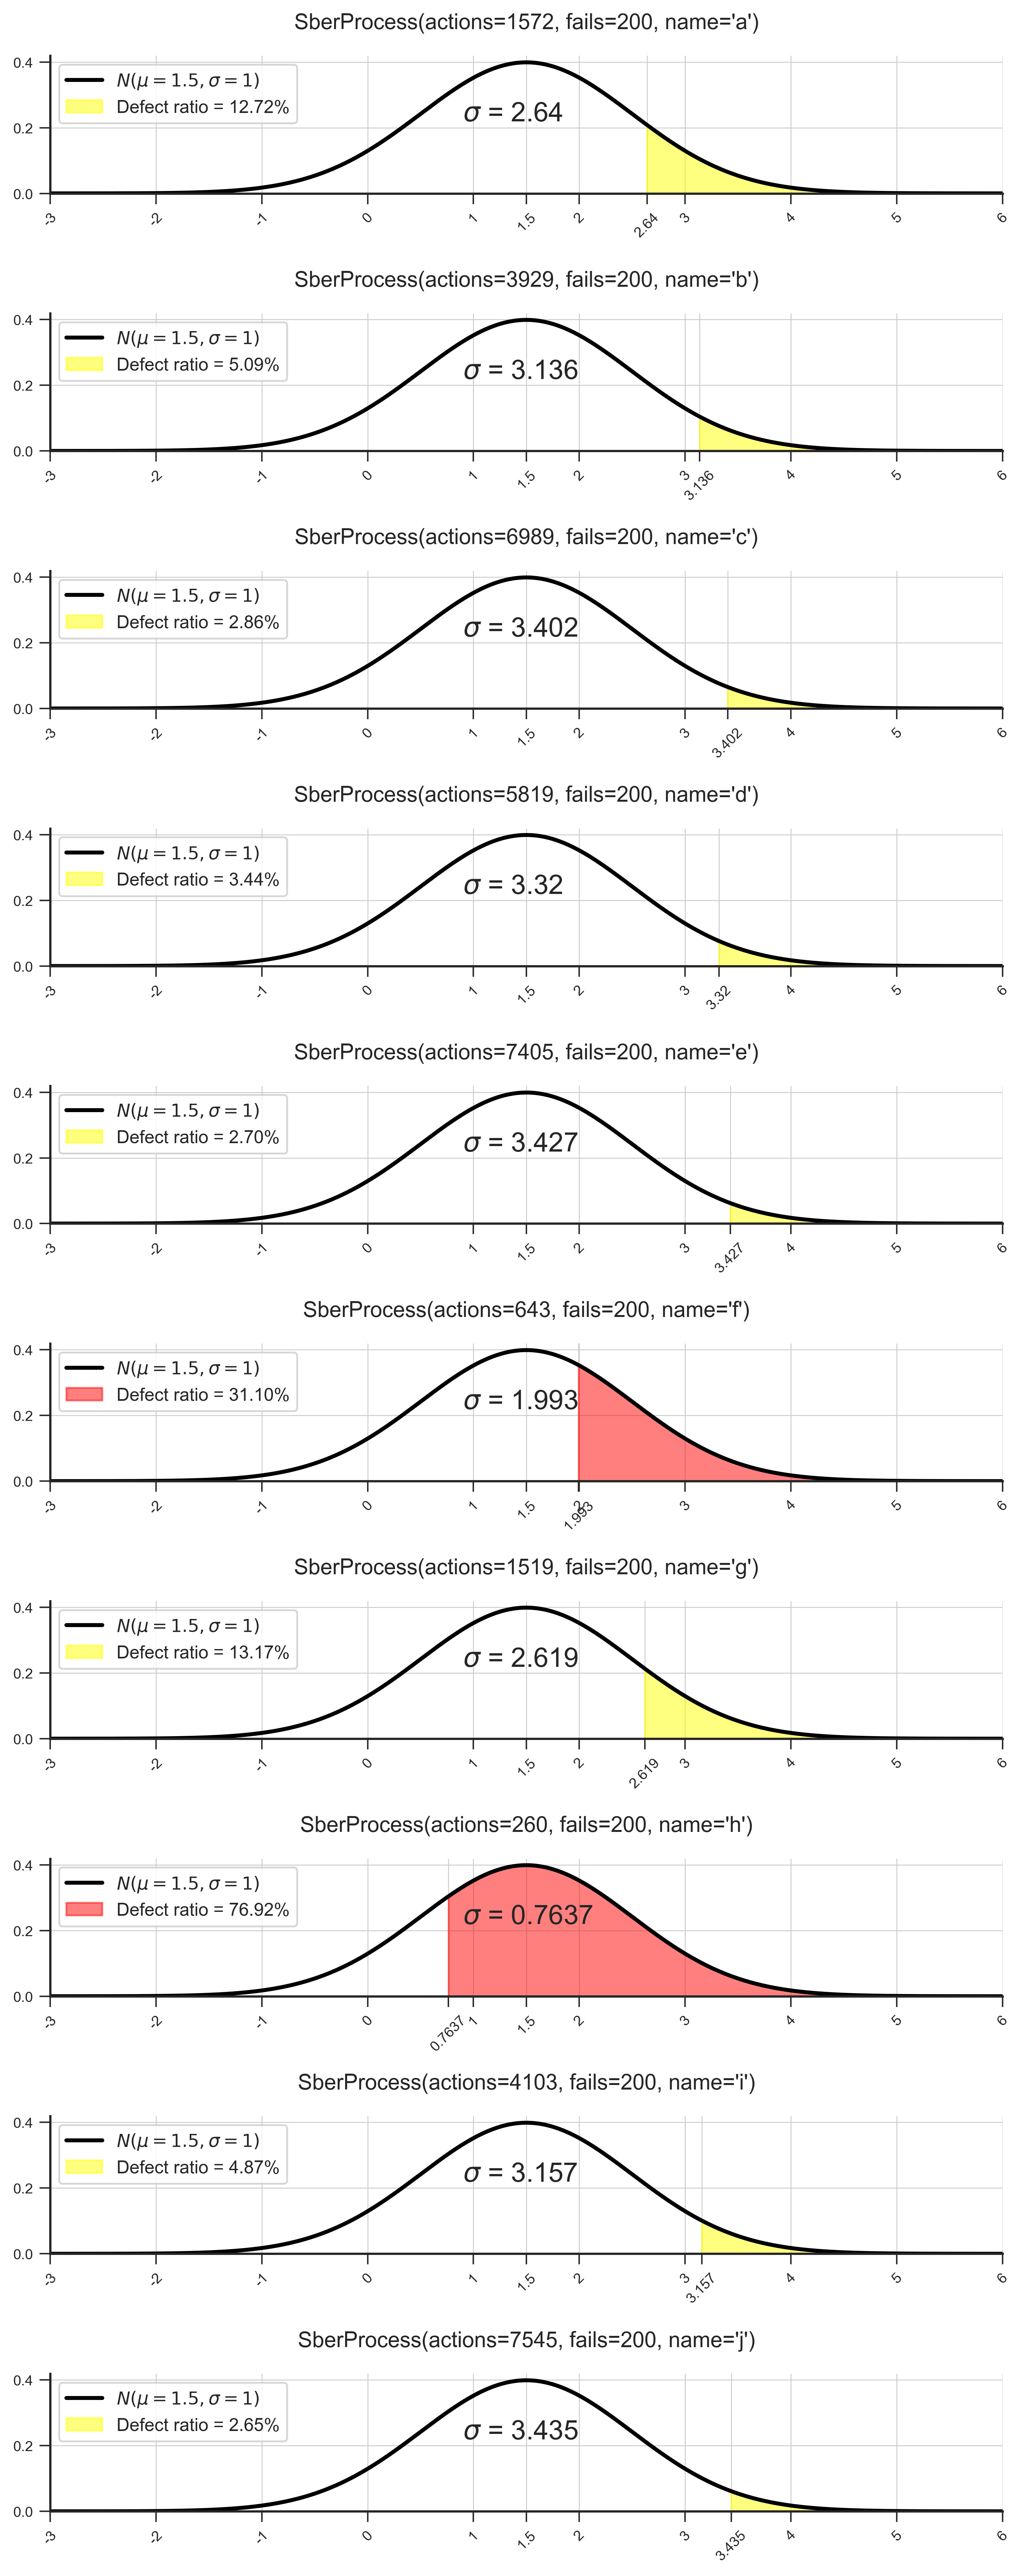

In [12]:
bulk.plot()

***
### <a id="toc1_1_5_"></a>[__Практический смысл__](#toc0_)

In [13]:
from scipy.stats import norm

In [14]:
ratios = [
    1 - norm(1.5).cdf(quality_class.supremum)
    for quality_class in classifier
]

ratios

[0.27425311775007355, 0.004661188023718732, 0.0]

* дефектов более 274253 на 1 млн действий: класс бездефектности `red`;
* от 4662 до 274253: `yellow`;
* менее 4662: `green`.

In [15]:
SberProcess(classifier, actions=10**6, fails=274254).label.item()

'red'

In [16]:
SberProcess(classifier, actions=10**6, fails=274253).label

array(['yellow'], dtype='<U6')

In [17]:
SberProcess(classifier, actions=10**6, fails=4662).label

array(['yellow'], dtype='<U6')

In [18]:
SberProcess(classifier, actions=10**6, fails=4661).label

array(['green'], dtype='<U5')